In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import json
from PIL import Image
import pickle
import time

from sklearn.model_selection import cross_val_score, KFold, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer
from sklearn.preprocessing import normalize

from define_dataset import define_dataset
from define_ext_dataset import define_ext_dataset
from ml_models import build_SVM, build_random_forest

In [2]:
dataset = define_dataset()
tr_set = dataset.tr_set
test_set = dataset.test_set
results_dict = dataset.results_dict
num_positives = dataset.num_positives
num_negatives = dataset.num_negatives

In [3]:
ext_dataset = define_ext_dataset()

ext_ts_set = ext_dataset.data
ext_results_dict = ext_dataset.results_dict
num_positive_ext = ext_dataset.num_positives
num_negatives_ext = ext_dataset.num_negatives
batch1_ext = ext_dataset.batch1
batch2_ext = ext_dataset.batch2
batch3_ext = ext_dataset.batch3

In [4]:
# Dicts with number of tiles for each slide
tiles_num_dict_path = './data/num_tiles_dict_tr.json'
with open(tiles_num_dict_path) as json_file:
    num_tiles_dict_tr = json.load(json_file)
    
tiles_num_dict_path = './data/num_tiles_dict_ts.json'
with open(tiles_num_dict_path) as json_file:
    num_tiles_dict_ts = json.load(json_file)

tiles_num_dict_path = './data/num_tiles_dict_ext.json'
with open(tiles_num_dict_path) as json_file:
    num_tiles_dict_ext = json.load(json_file)

In [5]:
epoch = 20
save_model_path = './ae_models/ae/'
embed_dim = 32

Paths

In [6]:
tr_avg_embed_pth = os.path.join("./avg_embed", "ae", "avg_embed_tr.npy")
ts_avg_embed_pth = os.path.join("./avg_embed", "ae", "avg_embed_ts.npy")
ext_avg_embed_pth = os.path.join("./avg_embed", "ae", "avg_embed_ext.npy")

# Calculate average embedding

For each slide, we calculate the average embedding over all of its tiles

In [7]:
def subdivide_embed_by_slide(embed_tiles, dataset='tr'):
    # Labels are still ordered by slide, ie the first 25000 tiles are from the first slide, tile 25001
    # to 70000 is from the second slide and so on
    
    if dataset=='ts':
        num_tiles_dict = num_tiles_dict_ts
    elif dataset=='ext':
        num_tiles_dict = num_tiles_dict_ext
    else:
        num_tiles_dict = num_tiles_dict_tr

    all_slides_embed_arr = []

    start = 0
    end = 0
    for slide_name in num_tiles_dict:
        slide_num_tiles = num_tiles_dict[slide_name]
        end += slide_num_tiles
        slide_embed = embed_tiles[start:end]
        start += slide_num_tiles
        all_slides_embed_arr.append(slide_embed)
        
    return all_slides_embed_arr

Tr set

In [8]:
embed_path_tr = os.path.join(save_model_path, 'z_ae_test_epoch{}.npy'.format(epoch))
embed_tiles_tr = np.load(embed_path_tr)

In [9]:
# Array containing, for each slide, the array of all the slide tiles embeddings
tr_slides_embed_arr = subdivide_embed_by_slide(embed_tiles_tr, 'tr')

In [10]:
tr_slides_avg_embed = np.zeros((len(tr_set), embed_dim))

for i, slide_embed in enumerate(tr_slides_embed_arr):
    avg_embed = np.average(slide_embed, axis=0)
    tr_slides_avg_embed[i] = avg_embed
    
np.save(tr_avg_embed_pth, tr_slides_avg_embed)

Test set

In [11]:
embed_path_ts = os.path.join(save_model_path, 'z_ae_internal_test_epoch{}.npy'.format(epoch))
embed_tiles_ts = np.load(embed_path_ts)

In [12]:
# Array containing, for each slide, the array of all the slide tiles embeddings
ts_slides_embed_arr = subdivide_embed_by_slide(embed_tiles_ts, 'ts')

In [13]:
ts_slides_avg_embed = np.zeros((len(test_set), embed_dim))

for i, slide_embed in enumerate(ts_slides_embed_arr):
    avg_embed = np.average(slide_embed, axis=0)
    ts_slides_avg_embed[i] = avg_embed
    
np.save(ts_avg_embed_pth, ts_slides_avg_embed)

Ext set

In [14]:
embed_path_ext = os.path.join(save_model_path, 'z_ae_ext_test_epoch{}.npy'.format(epoch))
embed_tiles_ext = np.load(embed_path_ext)

In [15]:
# Array containing, for each slide, the array of all the slide tiles embeddings
ext_slides_embed_arr = subdivide_embed_by_slide(embed_tiles_ext, 'ext')

In [16]:
ext_slides_avg_embed = np.zeros((len(ext_ts_set), embed_dim))

for i, slide_embed in enumerate(ext_slides_embed_arr):
    avg_embed = np.average(slide_embed, axis=0)
    ext_slides_avg_embed[i] = avg_embed
    
np.save(ext_avg_embed_pth, ext_slides_avg_embed)

 # Visualize average embedding

Tr set

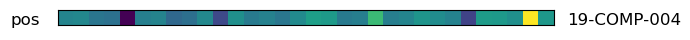

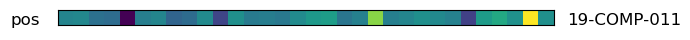

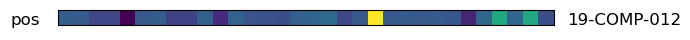

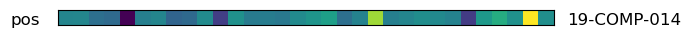

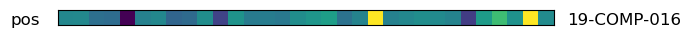

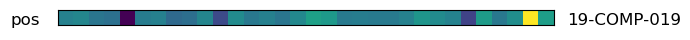

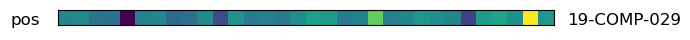

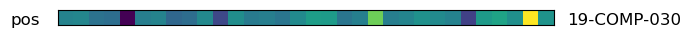

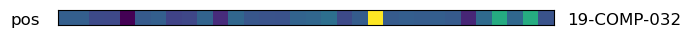

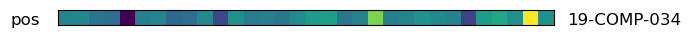

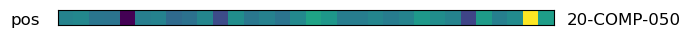

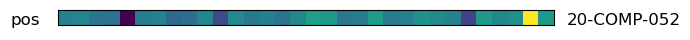

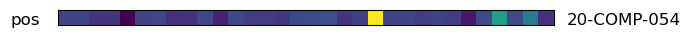

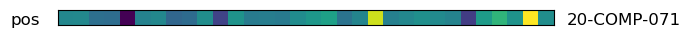

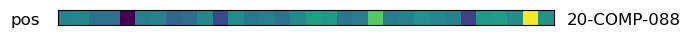

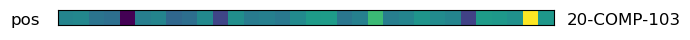

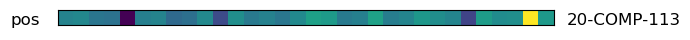

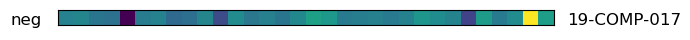

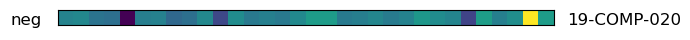

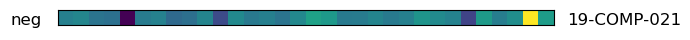

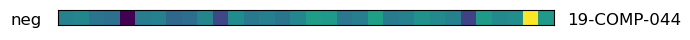

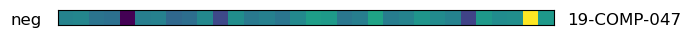

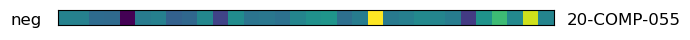

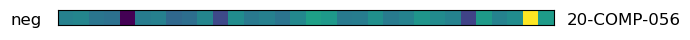

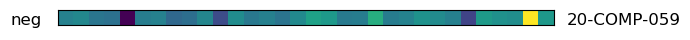

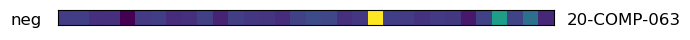

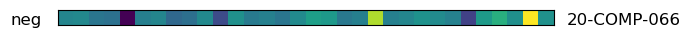

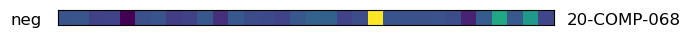

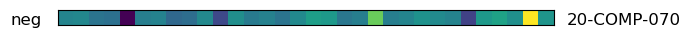

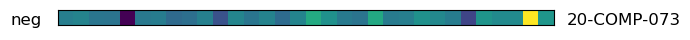

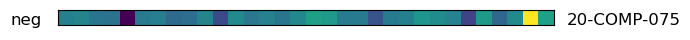

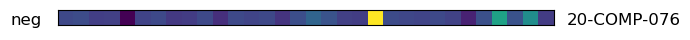

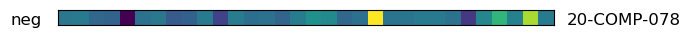

In [17]:
tr_slides_avg_embed = np.load(tr_avg_embed_pth)

for i, slide_name in enumerate(tr_set):
    slide_avg_embed = np.reshape(tr_slides_avg_embed[i], (1,len(tr_slides_avg_embed[i])))
    
    ax = plt.gca()
    plt.imshow(slide_avg_embed)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.gcf().text(0.92, 0.48, slide_name, fontsize=12)
    if results_dict[slide_name] == 1:
            positivity = 'pos'
    else:
            positivity = 'neg'
    plt.gcf().text(0.05, 0.48, positivity, fontsize=12)
    
    plt.show()

Test set

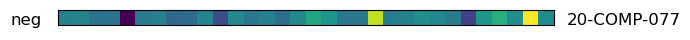

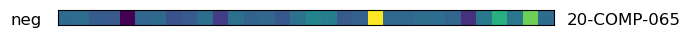

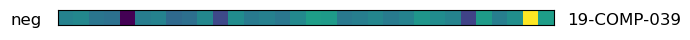

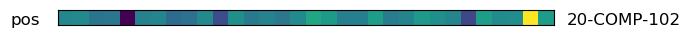

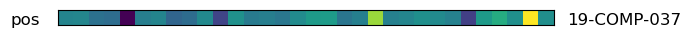

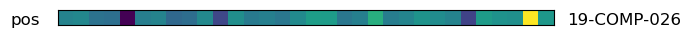

In [18]:
ts_slides_avg_embed = np.load(ts_avg_embed_pth)

for i, slide_name in enumerate(test_set):
    slide_avg_embed = np.reshape(ts_slides_avg_embed[i], (1,len(ts_slides_avg_embed[i])))
    
    ax = plt.gca()
    plt.imshow(slide_avg_embed)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.gcf().text(0.92, 0.48, slide_name, fontsize=12)
    if results_dict[slide_name] == 1:
            positivity = 'pos'
    else:
            positivity = 'neg'
    plt.gcf().text(0.05, 0.48, positivity, fontsize=12)
    
    plt.show()

Ext set

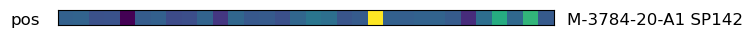

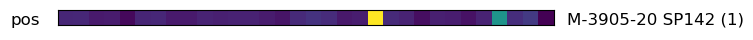

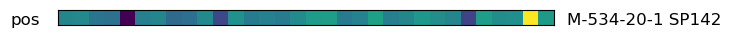

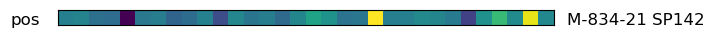

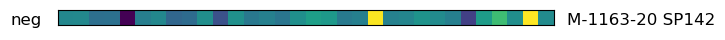

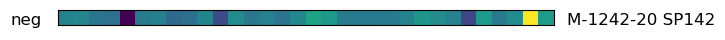

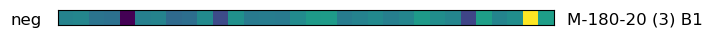

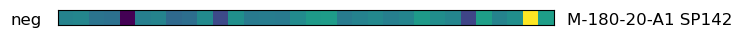

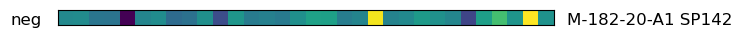

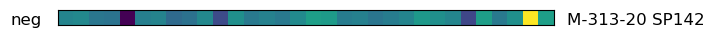

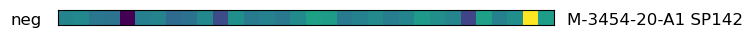

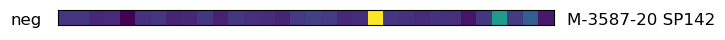

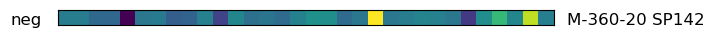

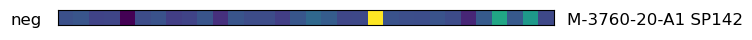

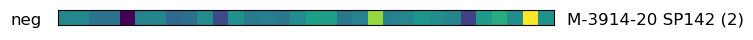

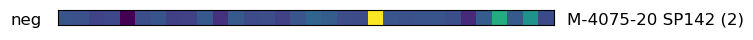

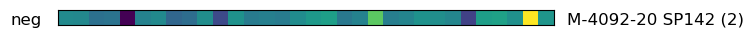

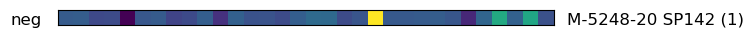

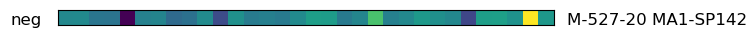

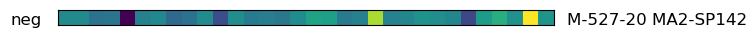

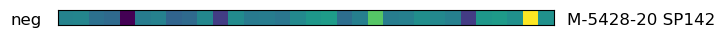

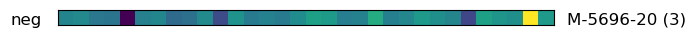

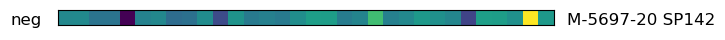

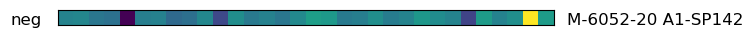

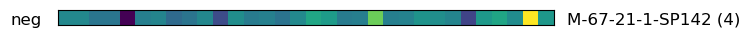

In [24]:
ext_slides_avg_embed = np.load(ext_avg_embed_pth)

for i, slide_name in enumerate(ext_ts_set):
    slide_avg_embed = np.reshape(ext_slides_avg_embed[i], (1,len(ext_slides_avg_embed[i])))
    
    ax = plt.gca()
    plt.imshow(slide_avg_embed)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.gcf().text(0.92, 0.48, slide_name, fontsize=12)
    if ext_results_dict[slide_name] == 1:
            positivity = 'pos'
    else:
            positivity = 'neg'
    plt.gcf().text(0.05, 0.48, positivity, fontsize=12)
    
    plt.show()

# Classification

Load inputs

In [20]:
tr_slides_avg_embed = np.load(tr_avg_embed_pth)
ts_slides_avg_embed = np.load(ts_avg_embed_pth)
ext_slides_avg_embed = np.load(ext_avg_embed_pth)

Load targets

In [21]:
targets_tr = np.zeros(np.shape(tr_set), dtype='int')
for i, slide_name in enumerate(tr_set):
    targets_tr[i] = results_dict[slide_name]
    
targets_ts = np.zeros(np.shape(test_set), dtype='int')
for i, slide_name in enumerate(test_set):
    targets_ts[i] = results_dict[slide_name]
    
targets_ext = np.zeros(np.shape(ext_ts_set), dtype='int')
for i, slide_name in enumerate(ext_ts_set):
    targets_ext[i] = ext_results_dict[slide_name]

In [22]:
# SVM
print('--- SVM ---')
print('Training:')
best_score_svm, best_svm = build_SVM(X=tr_slides_avg_embed, y=targets_tr)
print('Internal Test:')
pred = best_svm.predict(ts_slides_avg_embed)
acc_svm = accuracy_score(y_true=targets_ts, y_pred=pred)
f1_svm = f1_score(y_true=targets_ts, y_pred=pred)
f1_weight_svm = f1_score(y_true=targets_ts, y_pred=pred, average="weighted")

print('acc_score_svm:', acc_svm)
print('f1_score_svm:', f1_svm)
print('f1_weight_score_svm:', f1_weight_svm)
print('\n')

# Random forest
print('--- RANDOM FOREST ---')
print('Training:')
best_score_rf, best_rf = build_random_forest(X=tr_slides_avg_embed, y=targets_tr)
print('Internal Test:')
pred = best_rf.predict(ts_slides_avg_embed)
acc_rf = accuracy_score(y_true=targets_ts, y_pred=pred)
f1_rf = f1_score(y_true=targets_ts, y_pred=pred)
f1_weight_rf = f1_score(y_true=targets_ts, y_pred=pred, average="weighted")

print('acc_score_rf:', acc_rf)
print('f1_score_rf:', f1_rf)
print('f1_weight_score_rf:', f1_weight_rf)

# Save models
svm_pth = './avg_embed/ae/classification/class_ae_cluster_avg_emb/svm'
rf_pth = './avg_embed/ae/classification/class_ae_cluster_avg_emb/rf'

pickle.dump(best_svm, open(svm_pth, 'wb'))
pickle.dump(best_rf, open(rf_pth, 'wb'))

print('\n')

--- SVM ---
Training:
SVM - Best parameters set found:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVM - Best accuracy score found:
0.7833333333333333
Internal Test:
acc_score_svm: 0.8333333333333334
f1_score_svm: 0.8
f1_weight_score_svm: 0.8285714285714286


--- RANDOM FOREST ---
Training:
RF - Best parameters set found:
{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 64}
RF - Best accuraccy score found:
0.7277777777777777
Internal Test:
acc_score_rf: 0.8333333333333334
f1_score_rf: 0.8
f1_weight_score_rf: 0.8285714285714286




In [25]:
print('EXTERNAL TEST\n')



svm_pth = './avg_embed/ae/classification/class_ae_cluster_avg_emb/svm'
rf_pth = './avg_embed/ae/classification/class_ae_cluster_avg_emb/rf'


# SVM
print('--- SVM ---')
trained_svm = pickle.load(open(svm_pth, 'rb'))
pred = trained_svm.predict(ext_slides_avg_embed)
acc_svm = accuracy_score(y_true=targets_ext, y_pred=pred)
f1_svm = f1_score(y_true=targets_ext, y_pred=pred)
f1_weight_svm = f1_score(y_true=targets_ext, y_pred=pred, average="weighted")

print('acc_score_svm:', acc_svm)
print('f1_score_svm:', f1_svm)
print('f1_weight_score_svm:', f1_weight_svm)
print(pred)
print(targets_ext)
print('\n')

# Random forest
print('--- RANDOM FOREST ---')
trained_rf = pickle.load(open(rf_pth, 'rb'))
pred = trained_rf.predict(ext_slides_avg_embed)
acc_rf = accuracy_score(y_true=targets_ext, y_pred=pred)
f1_rf = f1_score(y_true=targets_ext, y_pred=pred)
f1_weight_rf = f1_score(y_true=targets_ext, y_pred=pred, average="weighted")

print('acc_score_rf:', acc_rf)
print('f1_score_rf:', f1_rf)
print('f1_weight_score_rf:', f1_weight_rf)
print(pred)
print(targets_ext)
print('\n')

EXTERNAL TEST

--- SVM ---
acc_score_svm: 0.64
f1_score_svm: 0.18181818181818182
f1_weight_score_svm: 0.6752447552447552
[0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


--- RANDOM FOREST ---
acc_score_rf: 0.48
f1_score_rf: 0.23529411764705882
f1_weight_score_rf: 0.5467379679144385
[0 1 1 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


